In [1]:
import os

current_dir = os.getcwd() # get the current working directory
current_dir

'/Users/maria/CodeInstitute/pp5/jupiter_notebooks'

In [2]:
os.chdir(os.path.dirname(current_dir)) # change directory to parent directory
print("The directory you are in is:", os.getcwd()) # print current directory

The directory you are in is: /Users/maria/CodeInstitute/pp5


## Load Data

In [3]:
import numpy as np
import pandas as pd

df = (pd.read_csv("outputs/datasets/collection/LoanDefault.csv")
      .drop(labels=["ID", "year"], axis=1))

df.head()

,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,loan_amount,rate_of_interest,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,116500,NaN,...,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
1,cf,Male,nopre,type2,p1,l1,nopc,b/c,206500,NaN,...,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
2,cf,Male,pre,type1,p1,l1,nopc,nob/c,406500,4.56,...,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
3,cf,Male,nopre,type1,p4,l1,nopc,nob/c,456500,4.25,...,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
4,cf,Joint,pre,type1,p1,l1,nopc,nob/c,696500,4.00,...,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0


## ML Pipeline with data

### Pipeline for Data Cleaning and Feature Engineering

custom transformer for LTV impute

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin

class LTVImputer(BaseEstimator, TransformerMixin):
    """
    Class to impute missing values in the LTV column of a DataFrame.
    """
    def fit(self, X, y=None):
        """
        Doesn't need fitting, it just needs to apply the transformation.
        """
        return self

    def transform(self, X):
        """
        Transform the data by imputing missing values in the LTV column
        using the formula.
        """
        X_copy = X.copy()
        X_copy.loc[X_copy["LTV"].isnull(), "LTV"] = (
            X_copy["loan_amount"] / X_copy["property_value"]
            ) * 100
        return X_copy

In [5]:
from sklearn.pipeline import Pipeline
from feature_engine.imputation import CategoricalImputer, MeanMedianImputer, ArbitraryNumberImputer
from feature_engine.outliers import OutlierTrimmer
from feature_engine.encoding import OrdinalEncoder
from feature_engine.transformation import LogTransformer, YeoJohnsonTransformer

def PipelineDataCleaningAndEngineering():

    # Categorical features and numerical features
    categorical_variables = ['loan_limit','Gender','approv_in_adv',
                             'loan_type','loan_purpose','Credit_Worthiness',
                             'open_credit','business_or_commercial',
                             'Neg_ammortization','interest_only',
                             'lump_sum_payment','construction_type',
                             'occupancy_type','Secured_by','total_units',
                             'credit_type','co-applicant_credit_type',
                             'age','submission_of_application','Region',
                             'Security_Type']
    median_variables = ["Upfront_charges",
                    "rate_of_interest",
                    "property_value",
                    "income"]
    mean_variables = ["Interest_rate_spread", "dtir1"]
    var_to_log = ["loan_amount", "property_value"]
    var_to_yeo = ["rate_of_interest"]

    # Impute missing values for categorical features
    categorical_imputer = CategoricalImputer(imputation_method="frequent")

    # Impute missing values for numerical features
    numerical_imputer_median = MeanMedianImputer(imputation_method="median", variables=median_variables)
    numerical_imputer_mean = MeanMedianImputer(imputation_method="mean", variables=mean_variables)
    numerical_imputer_max = ArbitraryNumberImputer(arbitrary_number=360.0, variables=["term"])

    # Outlier removal
    outlier_trimmer = OutlierTrimmer(capping_method="quantiles", fold=0.05, variables=["LTV"])

    # Encoding
    encoder = OrdinalEncoder(encoding_method="arbitrary", variables=categorical_variables)

    # Variable transformations (log and Yeo-Johnson)
    log_transf = LogTransformer(variables=var_to_log)
    yeo_transf = YeoJohnsonTransformer(variables=var_to_yeo)

    pipeline_base = Pipeline([
        ("CategoricalImputer", categorical_imputer),
        ("NumericalImputerMedian", numerical_imputer_median),
        ("NumericalImputerMean", numerical_imputer_mean),
        ("NumericalImputerMax", numerical_imputer_max),
        ("LTVImputer", LTVImputer()),
        ("OutlierTrimmer", outlier_trimmer),
        ("Encoder", encoder),
        ("LogTransformer", log_transf),
        ("YeoJohnsonTransformer", yeo_transf)
    ])

    return pipeline_base

PipelineDataCleaningAndEngineering()

Pipeline(steps=[('CategoricalImputer',
                 CategoricalImputer(imputation_method='frequent')),
                ('NumericalImputerMedian',
                 MeanMedianImputer(variables=['Upfront_charges',
                                              'rate_of_interest',
                                              'property_value', 'income'])),
                ('NumericalImputerMean',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['Interest_rate_spread',
                                              'dtir1'])),
                ('NumericalImputerMax',
                 Arbitr...
                                           'Neg_ammortization', 'interest_only',
                                           'lump_sum_payment',
                                           'construction_type',
                                           'occupancy_type', 'Secured_by',
                                           'total_units', 'credit_type',
                                           'co-applicant_credit_type', 'age',
                                           'submission_of_application',
                                           'Region', 'Security_Type'])),
                ('LogTransformer',
                 LogTransformer(variables=['loan_amount', 'property_value'])),
                ('YeoJohnsonTransformer',
                 YeoJohnsonTransformer(variables=['rate_of_interest']))])

## ML Pipeline for Modelling and Hyperparameter Optimisation

In [6]:
# Feat Scaling
from sklearn.preprocessing import StandardScaler

# Feat Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier


def PipelineClf(model):
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        ("feat_selection", SelectFromModel(model)),
        ("model", model),
    ])

    return pipeline_base

using custom function from CI

In [7]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")

            model = PipelineClf(self.models[key])
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, )
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches

## Split dataset

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['Status'], axis=1),
    df['Status'],
    test_size=0.2,
    random_state=0,
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(118936, 31) (118936,) (29734, 31) (29734,)


In [9]:
pipeline_data_cleaning_feat_eng = PipelineDataCleaningAndEngineering()
X_train = pipeline_data_cleaning_feat_eng.fit_transform(X_train)
y_train = y_train.loc[X_train.index]
X_test = pipeline_data_cleaning_feat_eng.transform(X_test)
y_test = y_test.loc[X_test.index]
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(113048, 31) (113048,) (28296, 31) (28296,)


maybe handle inbalance???? depends on the results - justify

---

## GridSearch CV

use standard hyperparameters to find the best algorithm

In [10]:
models_quick_search = {
    "LogisticRegression": LogisticRegression(random_state=0),
    "XGBClassifier": XGBClassifier(random_state=0),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=0),
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
}

params_quick_search = {
    "LogisticRegression": {},
    "XGBClassifier": {},
    "DecisionTreeClassifier": {},
    "RandomForestClassifier": {},
    "GradientBoostingClassifier": {},
    "ExtraTreesClassifier": {},
    "AdaBoostClassifier": {},
}

In [11]:
from sklearn.metrics import make_scorer, recall_score
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train,
           scoring = make_scorer(recall_score, pos_label=1),
           n_jobs=-1, cv=5)


Running GridSearchCV for LogisticRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [12]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score
1,XGBClassifier,1.0,1.0,1.0,0.0
2,DecisionTreeClassifier,1.0,1.0,1.0,0.0
3,RandomForestClassifier,1.0,1.0,1.0,0.0
4,GradientBoostingClassifier,1.0,1.0,1.0,0.0
5,ExtraTreesClassifier,1.0,1.0,1.0,0.0
6,AdaBoostClassifier,1.0,1.0,1.0,0.0
0,LogisticRegression,0.358674,0.362309,0.365272,0.002765


perfection as you can see. god help me.

### Assess feature importance

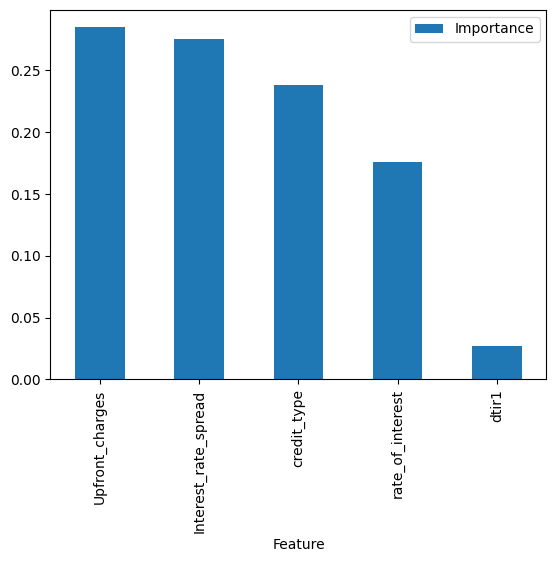

In [13]:
import matplotlib.pyplot as plt

pipeline_clf = grid_search_pipelines["ExtraTreesClassifier"].best_estimator_

df_feature_importance = (pd.DataFrame(data={
    'Feature': X_train.columns[pipeline_clf['feat_selection'].get_support()],
    'Importance': pipeline_clf['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# re-assign best_features order
best_features = df_feature_importance['Feature'].to_list()

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

In [14]:
from sklearn.model_selection import cross_val_score

scores_recall = cross_val_score(pipeline_clf, X_train, y_train, cv=5,scoring="recall")
scores_f1 = cross_val_score(pipeline_clf, X_train, y_train, cv=5, scoring="f1")

print("""%0.2f recall with a standard deviation of %0.2f 
and %0.2f F1 with standard deviation of %0.2f""" % 
(scores_recall.mean(), scores_recall.std(), 
 scores_f1.mean(), scores_f1.std()))


1.00 recall with a standard deviation of 0.00 
and 1.00 F1 with standard deviation of 0.00


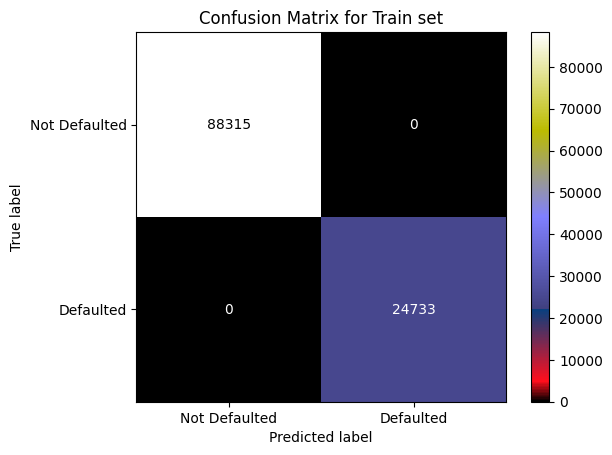

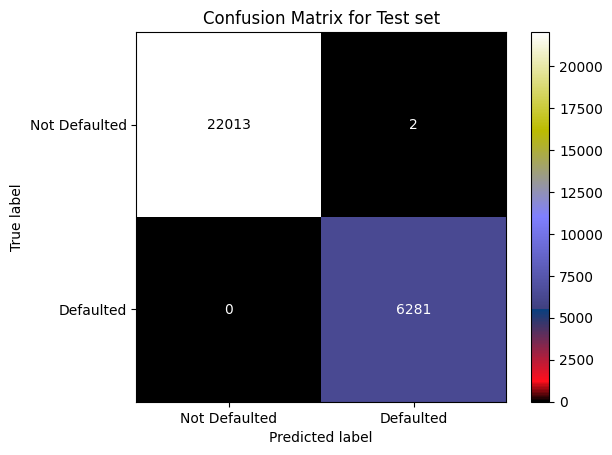

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Create confusion matrices

sets = [(X_train, y_train, "Train set"), (X_test, y_test, "Test set")]

for X_set, y_set, name in sets:
    predictions = pipeline_clf.predict(X_set)
    cm = confusion_matrix(y_set, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                    display_labels=["Not Defaulted", "Defaulted"])
    disp.plot(cmap="gist_stern")
    plt.title(f"Confusion Matrix for {name}")
    plt.show()

no need for report as the model is prediciting almost perfectly, so it is in the requirements for recall and balbala..


now redo the pipeline with only the most important features to save computing power

In [16]:
best_features

['Upfront_charges',
 'Interest_rate_spread',
 'credit_type',
 'rate_of_interest',
 'dtir1']

## Refit  using only best features

In [17]:
def PipelineOptimizedModel():
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        ("ExtraTreesClassifier", ExtraTreesClassifier()),
    ])

    return pipeline_base

## Split and impute

had to impute separately because something was not working when adding the steps inside the pipeline.

In [18]:
df_cleaned = df.copy().filter(items=(best_features+["Status"]))

impute_categorical = CategoricalImputer(imputation_method="frequent")
df_cleaned = impute_categorical.fit_transform(df_cleaned)

ordinal_encode = OrdinalEncoder(encoding_method="arbitrary")
df_cleaned = ordinal_encode.fit_transform(df_cleaned)

impute_meadian = MeanMedianImputer(
                                imputation_method="median",
                                variables=["Upfront_charges",
                                           "rate_of_interest"])
df_cleaned = impute_meadian.fit_transform(df_cleaned)

impute_mean = MeanMedianImputer(
                                imputation_method="mean",
                                variables=["Interest_rate_spread", "dtir1"])
df_cleaned = impute_mean.fit_transform(df_cleaned)

In [19]:
df_cleaned.isnull().sum()

Upfront_charges         0
Interest_rate_spread    0
credit_type             0
rate_of_interest        0
dtir1                   0
Status                  0
dtype: int64

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    df_cleaned.drop(['Status'], axis=1),
    df_cleaned["Status"],
    test_size=0.2,
    random_state=0,
)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((118936, 5), (118936,), (29734, 5), (29734,))

In [21]:
pipeline_optimized_model = PipelineOptimizedModel()
pipeline_optimized_model.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('ExtraTreesClassifier', ExtraTreesClassifier())])

test if the modekl is capable of prediction with less vars

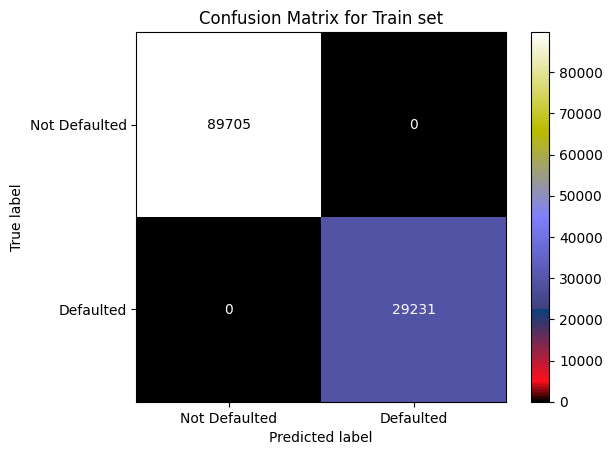

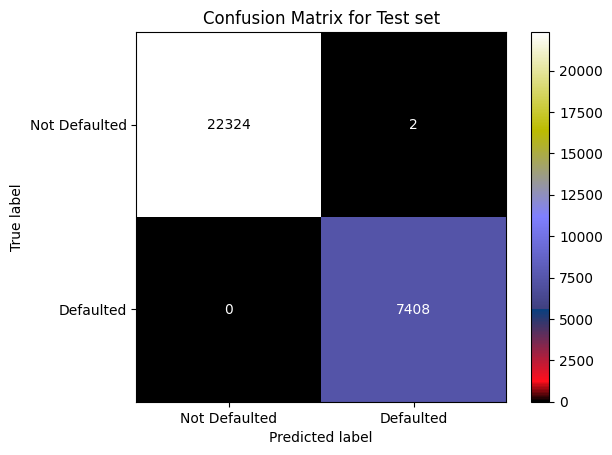

In [22]:
sets = [(X_train, y_train, "Train set"), (X_test, y_test, "Test set")]

for X_set, y_set, name in sets:
    predictions = pipeline_optimized_model.predict(X_set)
    cm = confusion_matrix(y_set, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=["Not Defaulted", "Defaulted"])
    disp.plot(cmap="gist_stern", values_format='d')
    plt.title(f"Confusion Matrix for {name}")
    plt.show()

so the file is perfoming the same way according to the confusion martix

## Push to repo


We will generate the following files

+ Train set
+ Test set
+ Modeling pipeline
+ features importance plot

In [23]:
import joblib

version = 'v1'
file_path = f'outputs/ml_pipeline/predict_status/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

[Errno 17] File exists: 'outputs/ml_pipeline/predict_status/v1'


In [24]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)
y_train.to_csv(f"{file_path}/y_train.csv", index=False)
X_test.to_csv(f"{file_path}/X_test.csv", index=False)
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

In [25]:
pipeline_optimized_model 

Pipeline(steps=[('scaler', StandardScaler()),
                ('ExtraTreesClassifier', ExtraTreesClassifier())])

In [26]:
joblib.dump(value=pipeline_optimized_model, filename=f"{file_path}/pipeline_optimized_model.pkl")

['outputs/ml_pipeline/predict_status/v1/pipeline_optimized_model.pkl']

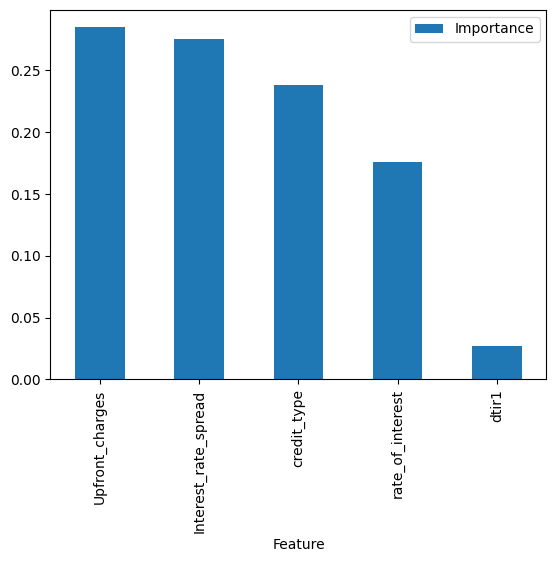

In [27]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')